# __Overview of the NASA Turbofan Jet Engine Data Set__
The NASA Turbofan Jet Engine dataset is designed to simulate the degradation of jet engines over time, with the goal of predicting the Remaining Useful Life (RUL) of each engine. This dataset was created by the Prognostics CoE at NASA Ames and is widely used in research and industry for developing predictive maintenance models.

## __Dataset Structure__
The dataset typically consists of multiple files corresponding to different conditions and scenarios. These files include:

### __Training Data (train_FD001.txt, train_FD002.txt, etc.):__

1. __Purpose:__ This data is used to train your predictive models.
2. __Content:__ It includes time-series data for multiple engines, recording various sensor readings at different time cycles until the engines fail.
3. __Columns:__

    - __Engine ID:__ Identifies each engine (unique for each engine).
    - __Cycle:__ The time cycle number, indicating the engine's operation stage.
    - __Operational Settings (3 columns):__ Different settings that influence the engine's performance, such as altitude, temperature, or power setting.
    - __Sensor Measurements (21 columns):__ Data from various sensors that monitor the engine's performance (e.g., temperature, pressure, vibration).
### __Test Data (test_FD001.txt, test_FD002.txt, etc.):__

1. __Purpose:__ Used for evaluating the model's performance.
2. __Content:__ Similar to the training data but the engines in this dataset have not failed by the end of the recorded cycles.
3. __Objective:__ Predict the RUL for these engines based on their current and past sensor readings.
### __RUL Data (RUL_FD001.txt, RUL_FD002.txt, etc.):__

1. __Purpose:__ Contains the actual Remaining Useful Life for each engine in the test set.
2. __Content:__ A single value for each engine, representing the number of cycles left before the engine fails.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
columns = ['engine_id', 'cycle'] + [f'operational_setting_{i}' for  i in range(1,4)] + [f'sensor_measurement_{i}' for i in range(1,22)]
train_data = pd.read_csv("data/train_FD001.txt", delim_whitespace=True, header=None, names=columns)
test_data = pd.read_csv("data/test_FD001.txt", delim_whitespace=True, header=None, names=columns)
rul_data = pd.read_csv("data/RUL_FD001.txt", delim_whitespace=True, header=None, names=["RUL"])
train_data.head()

engine_id  cycle  operational_setting_1  operational_setting_2  \
0          1      1                -0.0007                -0.0004   
1          1      2                 0.0019                -0.0003   
2          1      3                -0.0043                 0.0003   
3          1      4                 0.0007                 0.0000   
4          1      5                -0.0019                -0.0002   

   operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
0                  100.0                518.67                641.82   
1                  100.0                518.67                642.15   
2                  100.0                518.67                642.35   
3                  100.0                518.67                642.35   
4                  100.0                518.67                642.37   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  ...  \
0               1589.70               1400.60                 14.62  ...   
1               1591.82               1403.14                 14.62  ...   
2               1587.99               1404.20                 14.62  ...   
3               1582.79               1401.87                 14.62  ...   
4               1582.85               1406.22                 14.62  ...   

   sensor_measurement_12  sensor_measurement_13  sensor_measurement_14  \
0                 521.66                2388.02                8138.62   
1                 522.28                2388.07                8131.49   
2                 522.42                2388.03                8133.23   
3                 522.86                2388.08                8133.83   
4                 522.19                2388.04                8133.80   

   sensor_measurement_15  sensor_measurement_16  sensor_measurement_17  \
0                 8.4195                   0.03                    392   
1                 8.4318                   0.03                    392   
2                 8.4178                   0.03                    390   
3                 8.3682                   0.03                    392   
4                 8.4294                   0.03                    393   

   sensor_measurement_18  sensor_measurement_19  sensor_measurement_20  \
0                   2388                  100.0                  39.06   
1                   2388                  100.0                  39.00   
2                   2388                  100.0                  38.95   
3                   2388                  100.0                  38.88   
4                   2388                  100.0                  38.90   

   sensor_measurement_21  
0                23.4190  
1                23.4236  
2                23.3442  
3                23.3739  
4                23.4044  

[5 rows x 26 columns]

In [3]:
print(train_data.isnull().sum())

engine_id                0
cycle                    0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
sensor_measurement_1     0
sensor_measurement_2     0
sensor_measurement_3     0
sensor_measurement_4     0
sensor_measurement_5     0
sensor_measurement_6     0
sensor_measurement_7     0
sensor_measurement_8     0
sensor_measurement_9     0
sensor_measurement_10    0
sensor_measurement_11    0
sensor_measurement_12    0
sensor_measurement_13    0
sensor_measurement_14    0
sensor_measurement_15    0
sensor_measurement_16    0
sensor_measurement_17    0
sensor_measurement_18    0
sensor_measurement_19    0
sensor_measurement_20    0
sensor_measurement_21    0
dtype: int64


In [4]:
rul_train = train_data.groupby('engine_id')['cycle'].max().reset_index()
rul_train.columns = ['engine_id','max_cycle']
train_data = train_data.merge(rul_train, on=['engine_id'], how= 'left')
train_data['RUL'] = train_data['max_cycle'] - train_data['cycle']
train_data.drop('max_cycle', axis=1, inplace=True)

train_data.head()

engine_id  cycle  operational_setting_1  operational_setting_2  \
0          1      1                -0.0007                -0.0004   
1          1      2                 0.0019                -0.0003   
2          1      3                -0.0043                 0.0003   
3          1      4                 0.0007                 0.0000   
4          1      5                -0.0019                -0.0002   

   operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
0                  100.0                518.67                641.82   
1                  100.0                518.67                642.15   
2                  100.0                518.67                642.35   
3                  100.0                518.67                642.35   
4                  100.0                518.67                642.37   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  ...  \
0               1589.70               1400.60                 14.62  ...   
1               1591.82               1403.14                 14.62  ...   
2               1587.99               1404.20                 14.62  ...   
3               1582.79               1401.87                 14.62  ...   
4               1582.85               1406.22                 14.62  ...   

   sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                2388.02                8138.62                 8.4195   
1                2388.07                8131.49                 8.4318   
2                2388.03                8133.23                 8.4178   
3                2388.08                8133.83                 8.3682   
4                2388.04                8133.80                 8.4294   

   sensor_measurement_16  sensor_measurement_17  sensor_measurement_18  \
0                   0.03                    392                   2388   
1                   0.03                    392                   2388   
2                   0.03                    390                   2388   
3                   0.03                    392                   2388   
4                   0.03                    393                   2388   

   sensor_measurement_19  sensor_measurement_20  sensor_measurement_21  RUL  
0                  100.0                  39.06                23.4190  191  
1                  100.0                  39.00                23.4236  190  
2                  100.0                  38.95                23.3442  189  
3                  100.0                  38.88                23.3739  188  
4                  100.0                  38.90                23.4044  187  

[5 rows x 27 columns]

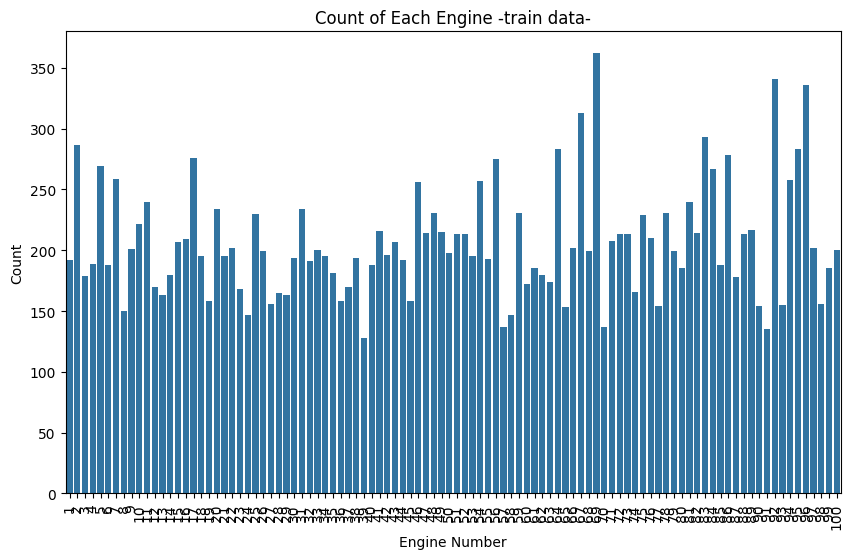

In [5]:
engine_counts = train_data['engine_id'].value_counts().reset_index()
engine_counts.columns = ['engine_id','count']
plt.figure(figsize=(10,6))
sns.barplot(x='engine_id',y='count',data=engine_counts)
plt.title('Count of Each Engine -train data-')
plt.xlabel('Engine Number')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


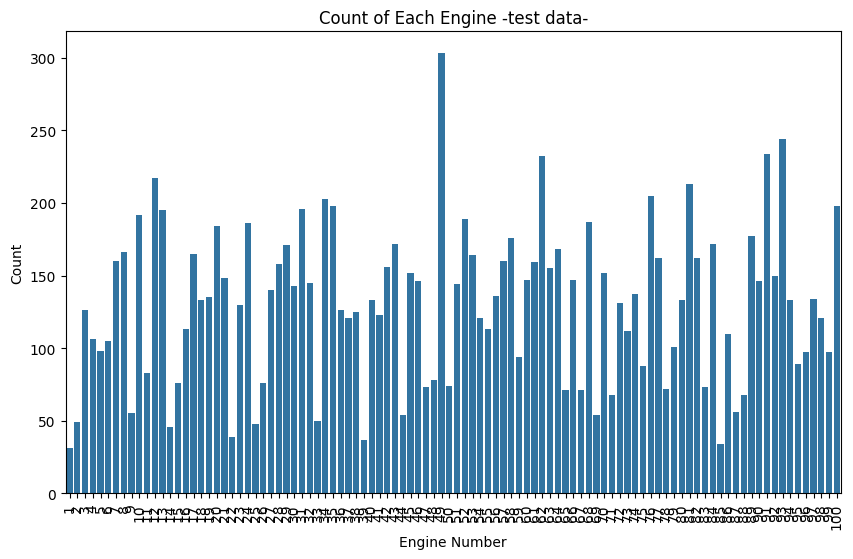

In [6]:
test_data.head()

engine_counts = test_data['engine_id'].value_counts().reset_index()
engine_counts.columns = ['engine_id','count']

plt.figure(figsize=(10,6))
sns.barplot(x='engine_id',y='count',data=engine_counts)
plt.title('Count of Each Engine -test data-')
plt.xlabel('Engine Number')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


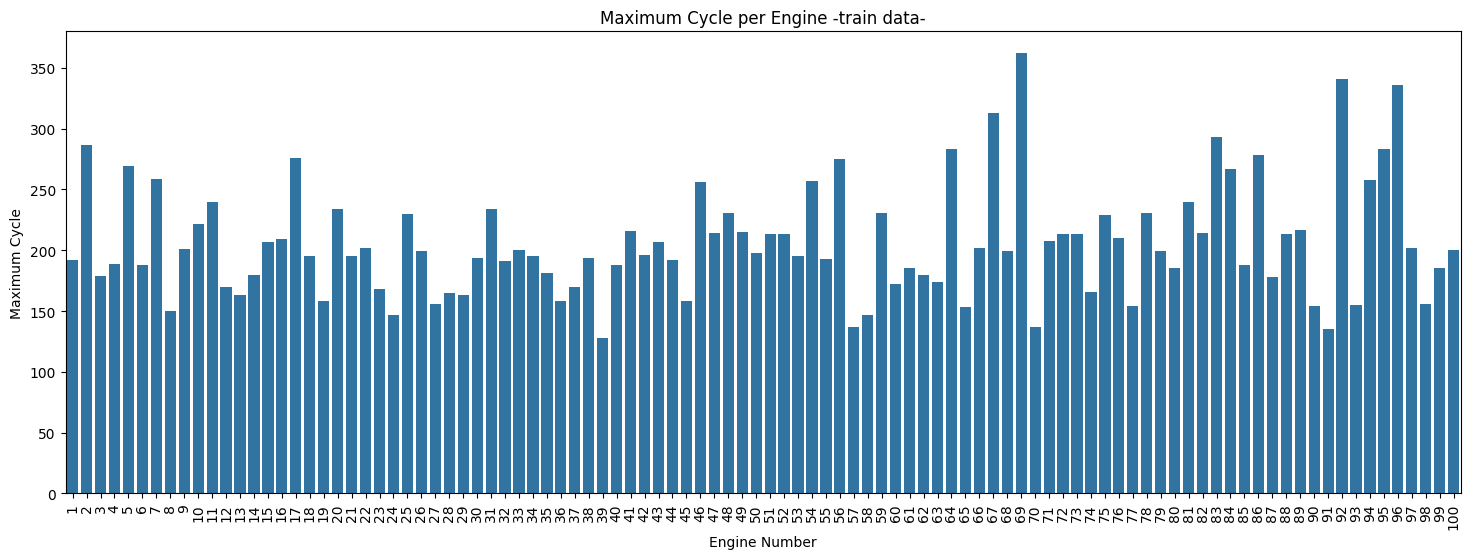

In [7]:
max_cycle = train_data.groupby('engine_id')['cycle'].max().reset_index()
max_cycle.columns = ['engine_id','max_cycle']

max_cycle.head()
plt.figure(figsize=(18, 6))
sns.barplot(x="engine_id",y='max_cycle',data=max_cycle)
plt.title('Maximum Cycle per Engine -train data-')
plt.xlabel('Engine Number')
plt.ylabel('Maximum Cycle')
plt.xticks(rotation=90)
plt.show()

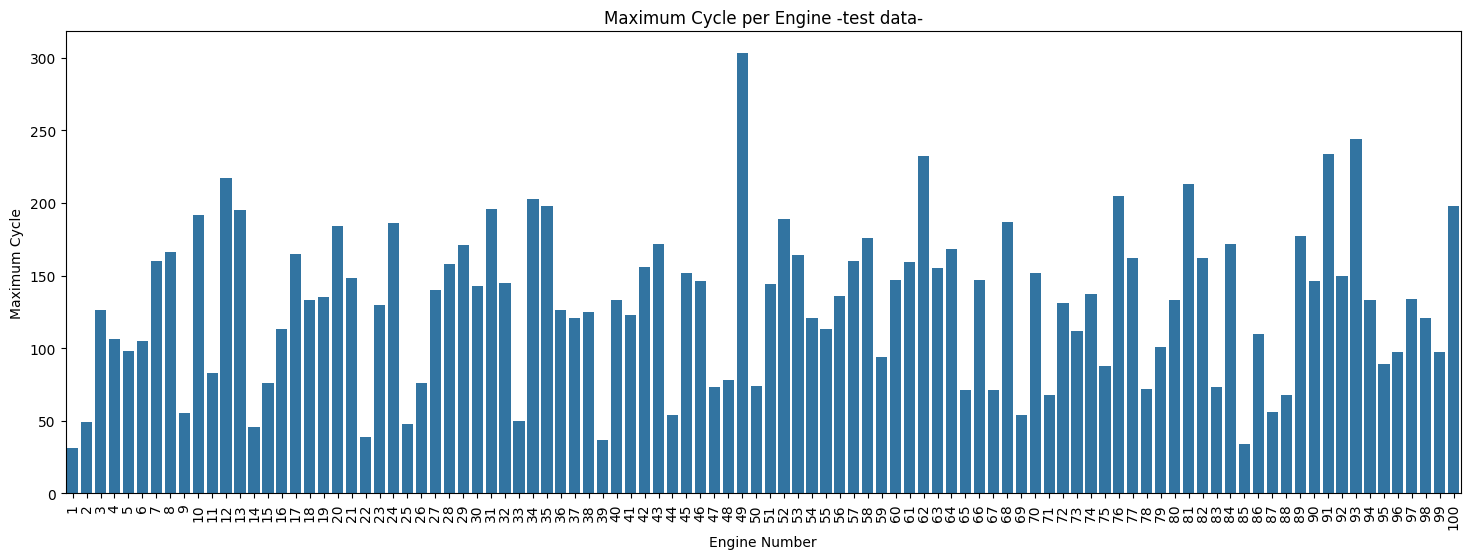

In [8]:
max_cycle = test_data.groupby('engine_id')['cycle'].max().reset_index()
max_cycle.columns = ['engine_id','max_cycle']

max_cycle.head()
plt.figure(figsize=(18, 6))
sns.barplot(x="engine_id",y='max_cycle',data=max_cycle)
plt.title('Maximum Cycle per Engine -test data-')
plt.xlabel('Engine Number')
plt.ylabel('Maximum Cycle')
plt.xticks(rotation=90)
plt.show()

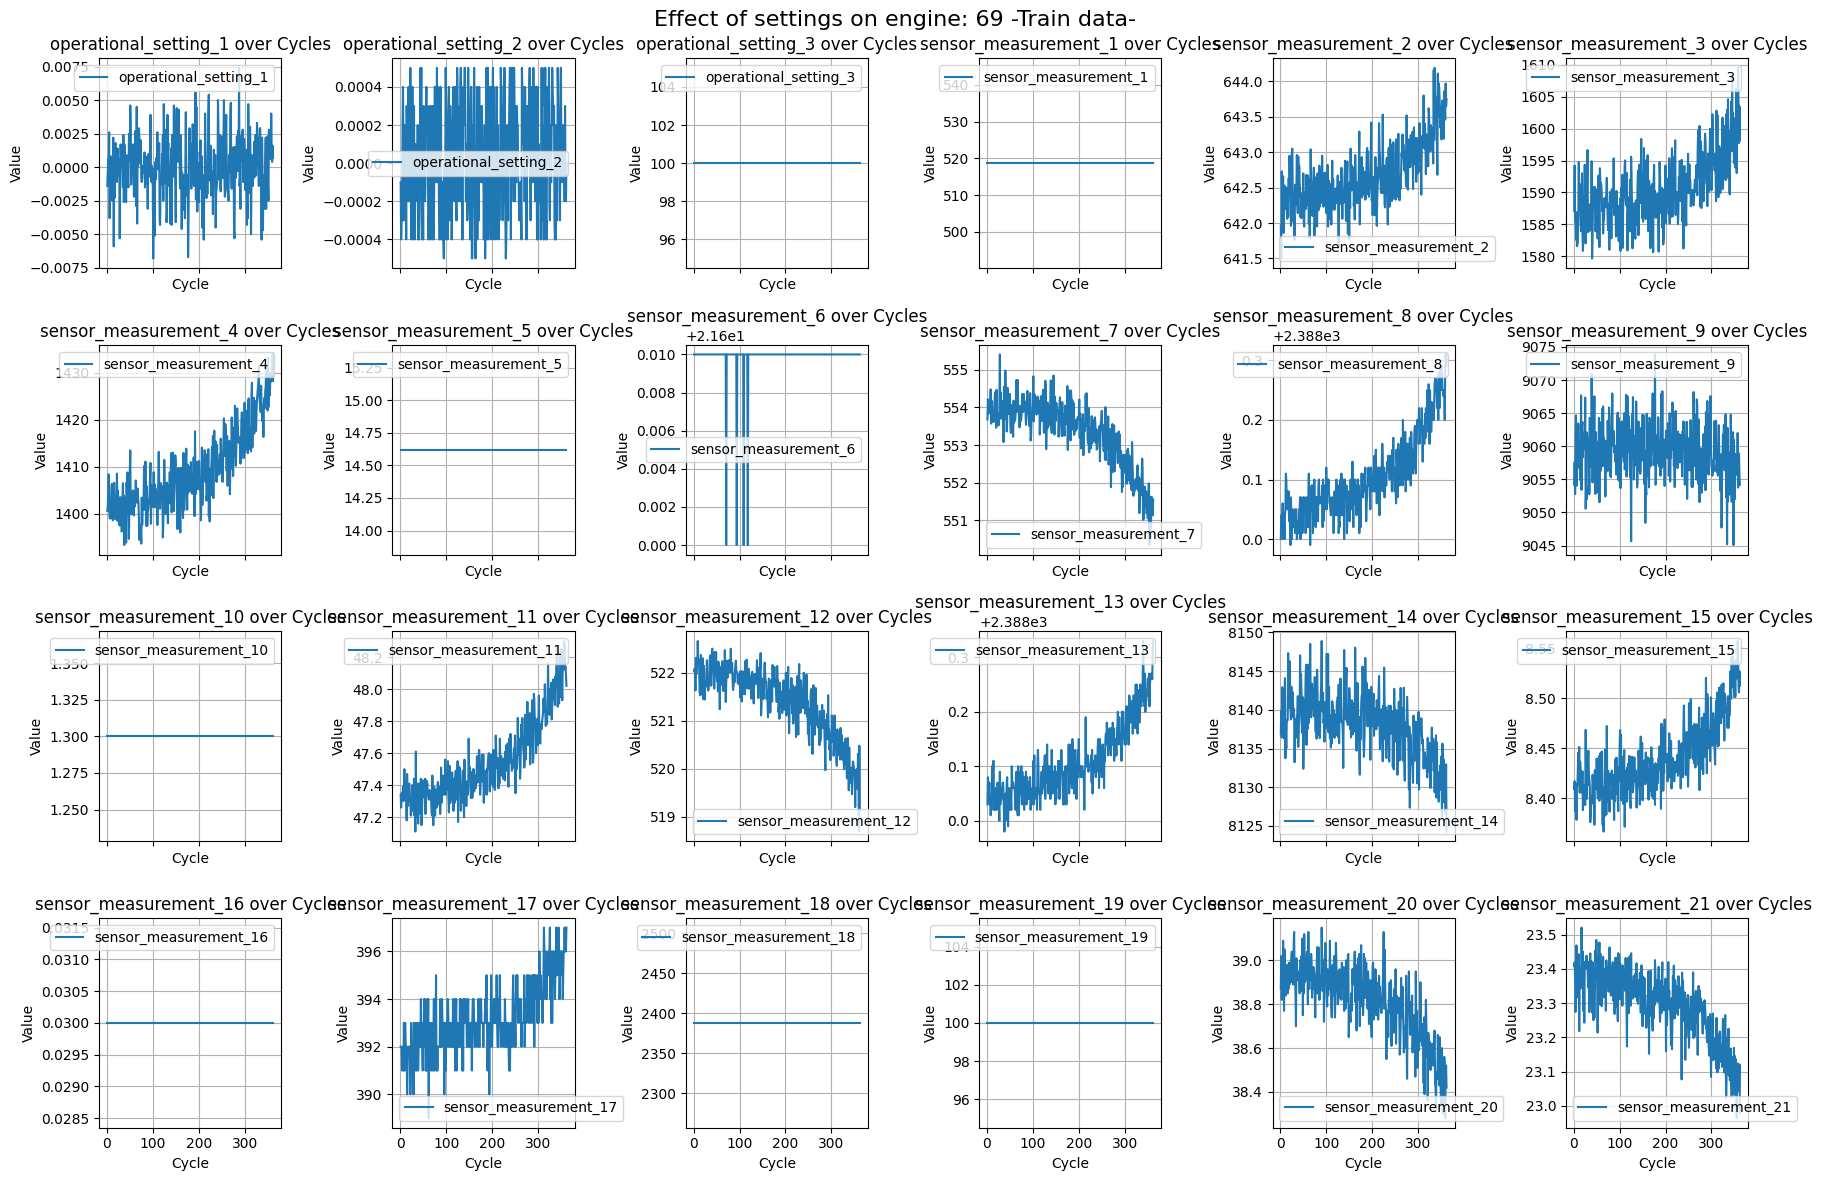

In [9]:
engine_number  = 69
engine_data = train_data[train_data['engine_id']==engine_number]

columns_to_plot = [f'operational_setting_{i}' for  i in range(1,4)] + [f'sensor_measurement_{i}' for i in range(1,22)]
num_cols = 6
num_rows = (len(columns_to_plot)  // num_cols)

fig,axes = plt.subplots(num_rows,num_cols,figsize=(18, num_rows * 3), sharex=True)

for ax, column in zip(axes.flatten(), columns_to_plot):
    ax.plot(engine_data['cycle'], engine_data[column], label=column)
    ax.set_title(f'{column} over Cycles')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

# Adjust the layout so that subgraphs do not overlap
plt.suptitle(f"Effect of settings on engine: {engine_number} -Train data-",fontsize=16)
plt.tight_layout()
plt.show()



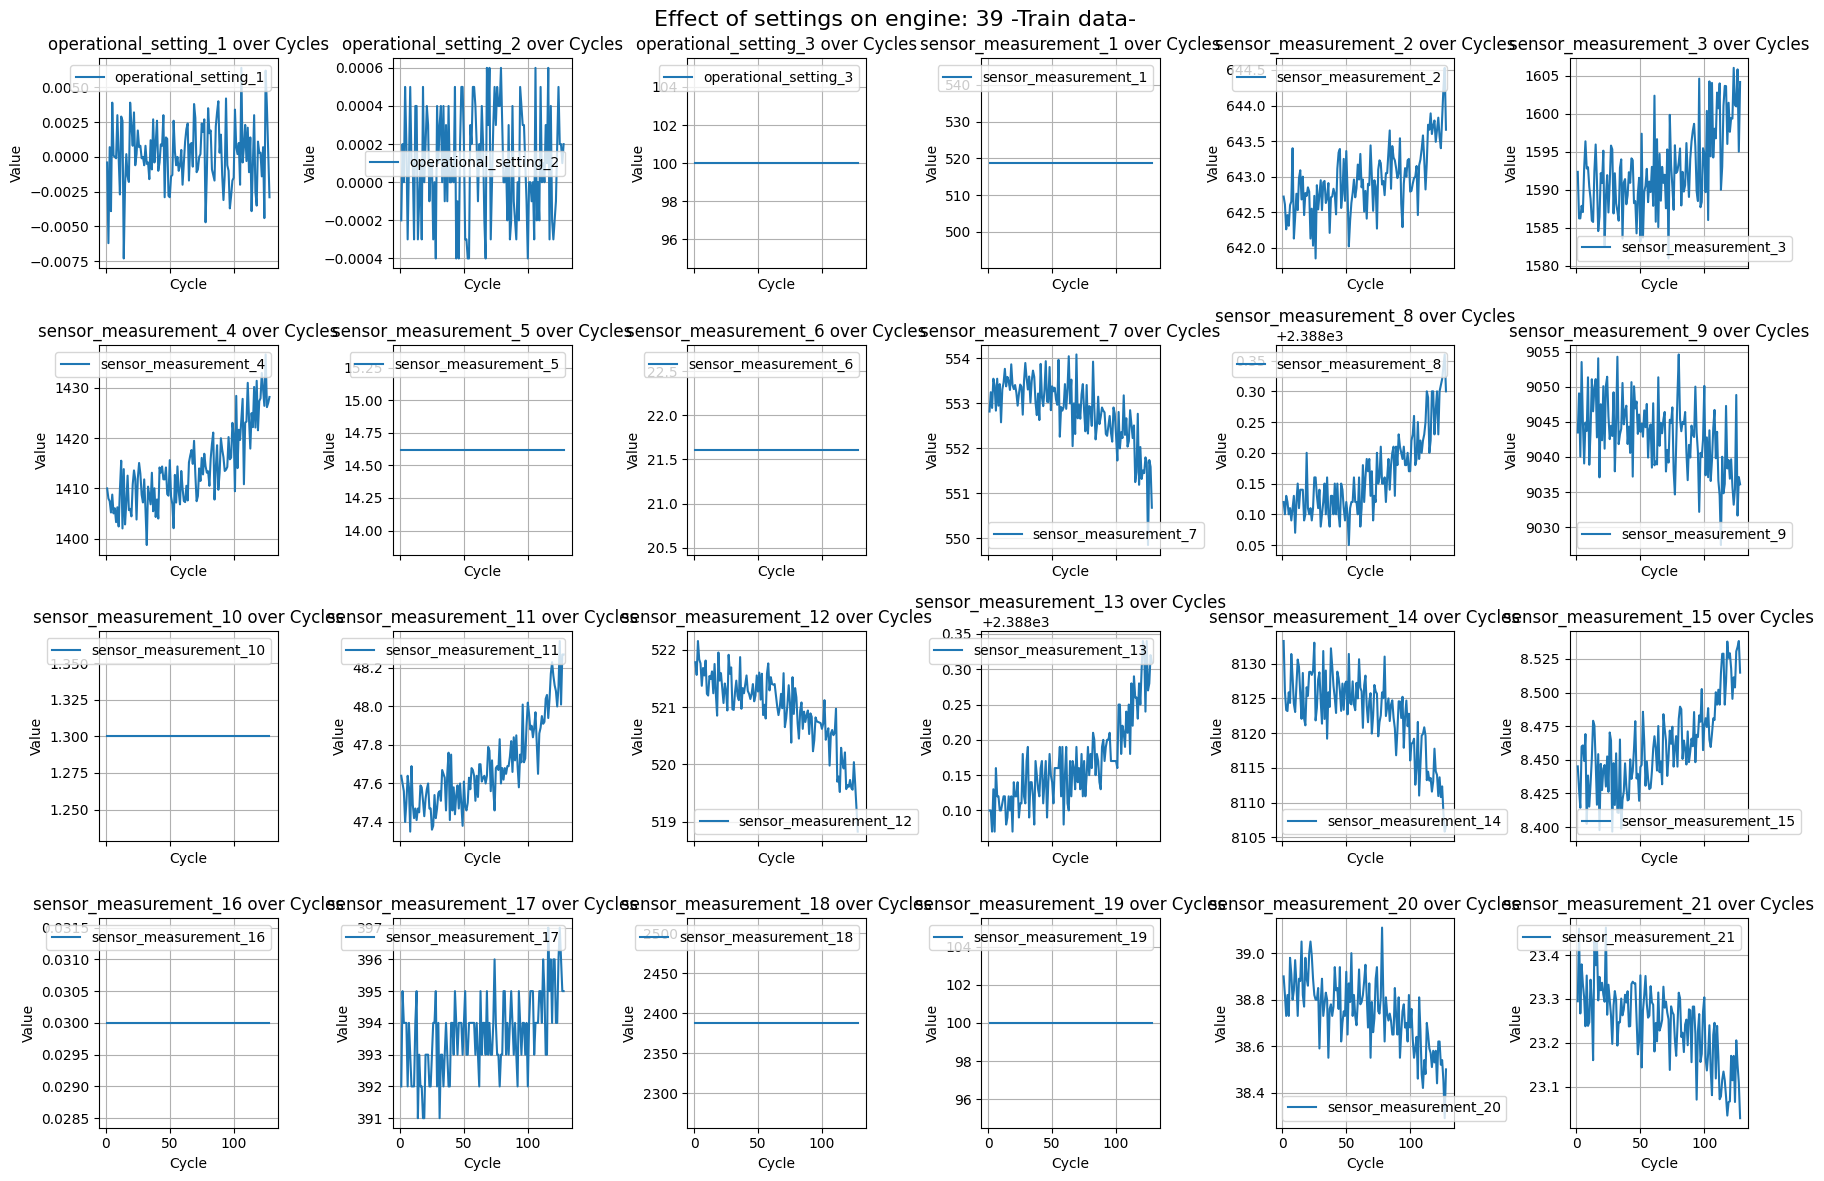

In [10]:
engine_number  = 39
engine_data = train_data[train_data['engine_id']==engine_number]

columns_to_plot = [f'operational_setting_{i}' for  i in range(1,4)] + [f'sensor_measurement_{i}' for i in range(1,22)]
num_cols = 6
num_rows = (len(columns_to_plot)  // num_cols)

fig,axes = plt.subplots(num_rows,num_cols,figsize=(18, num_rows * 3), sharex=True)

for ax, column in zip(axes.flatten(), columns_to_plot):
    ax.plot(engine_data['cycle'], engine_data[column], label=column)
    ax.set_title(f'{column} over Cycles')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

# Adjust the layout so that subgraphs do not overlap
plt.suptitle(f"Effect of settings on engine: {engine_number} -Train data-",fontsize=16)
plt.tight_layout()
plt.show()

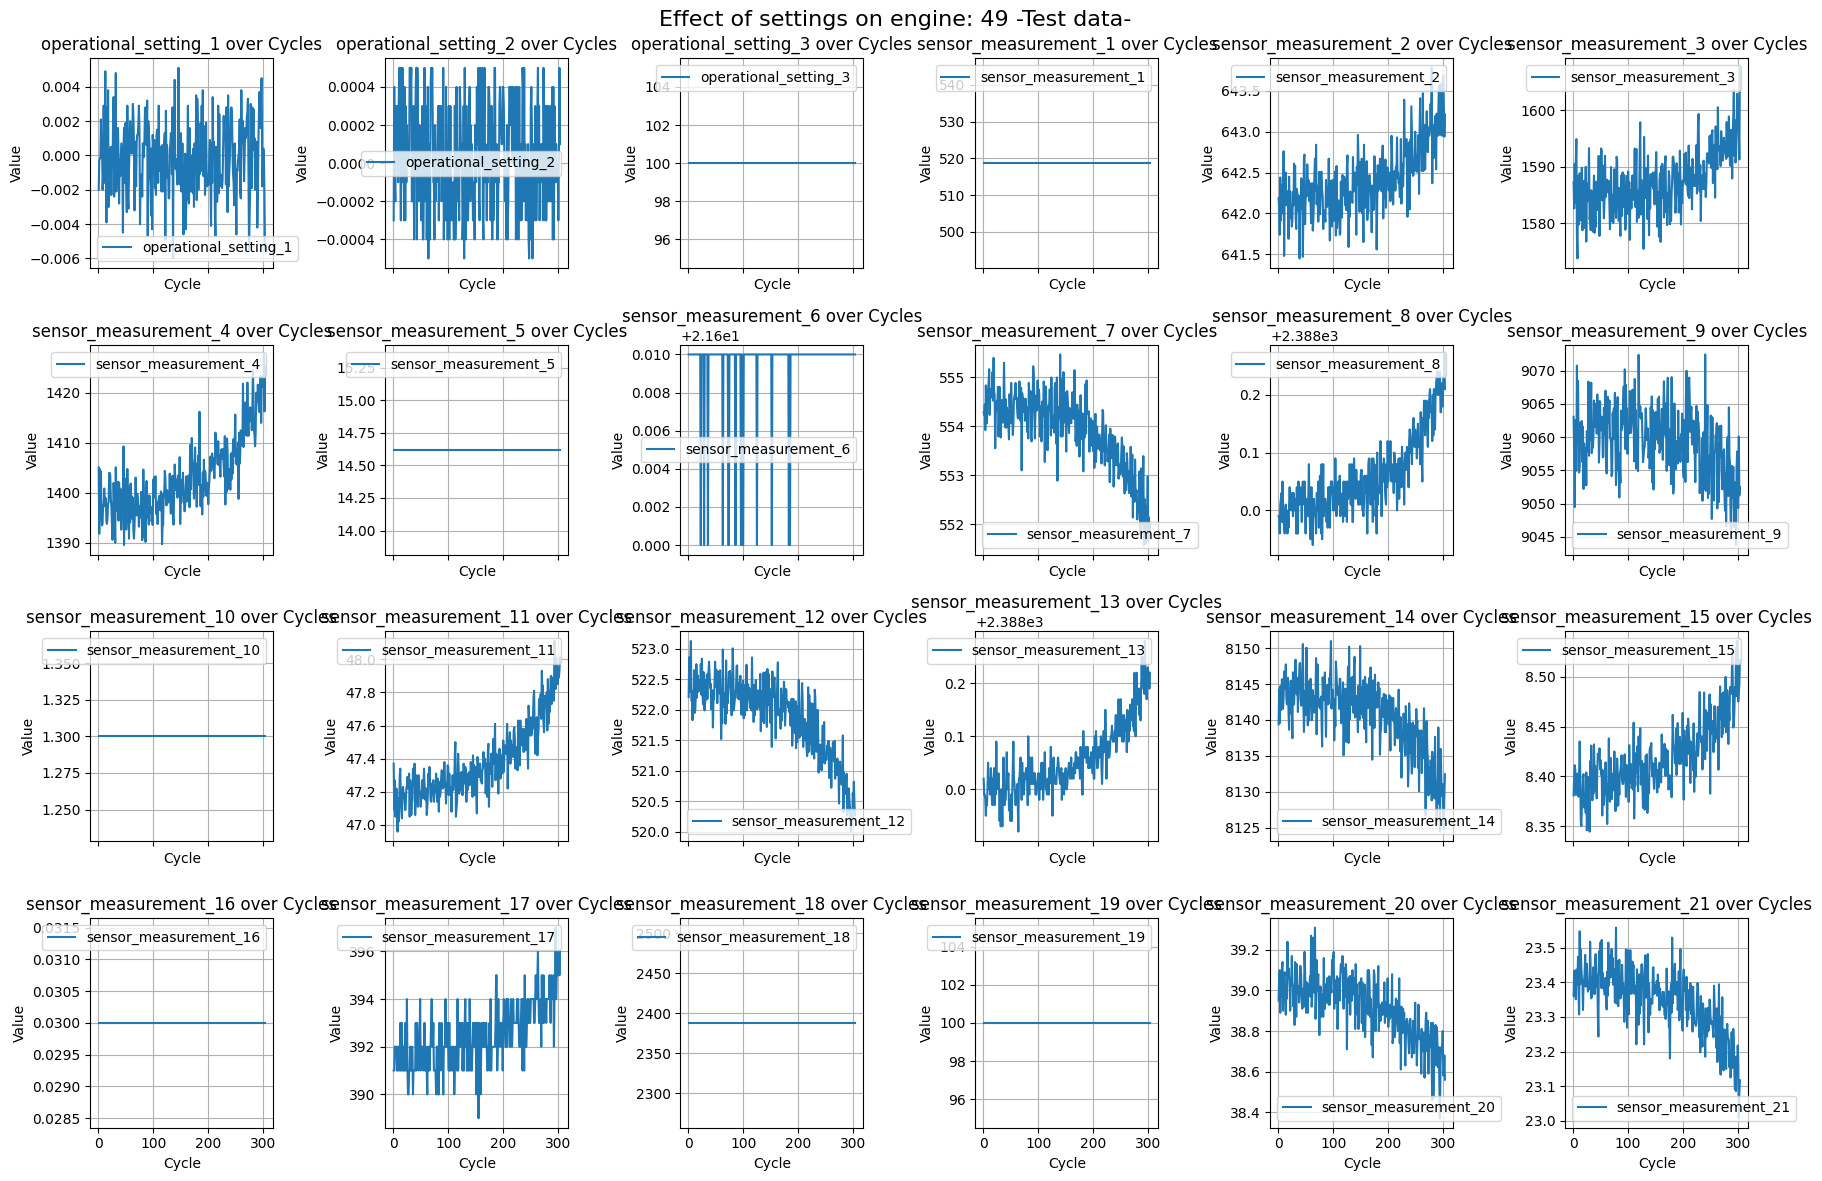

In [11]:
engine_number  = 49
engine_data = test_data[test_data['engine_id']==engine_number]

columns_to_plot = [f'operational_setting_{i}' for  i in range(1,4)] + [f'sensor_measurement_{i}' for i in range(1,22)]
num_cols = 6
num_rows = (len(columns_to_plot)  // num_cols)

fig,axes = plt.subplots(num_rows,num_cols,figsize=(18, num_rows * 3), sharex=True)

for ax, column in zip(axes.flatten(), columns_to_plot):
    ax.plot(engine_data['cycle'], engine_data[column], label=column)
    ax.set_title(f'{column} over Cycles')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

# Adjust the layout so that subgraphs do not overlap
plt.suptitle(f"Effect of settings on engine: {engine_number} -Test data-",fontsize=16)
plt.tight_layout()
plt.show()


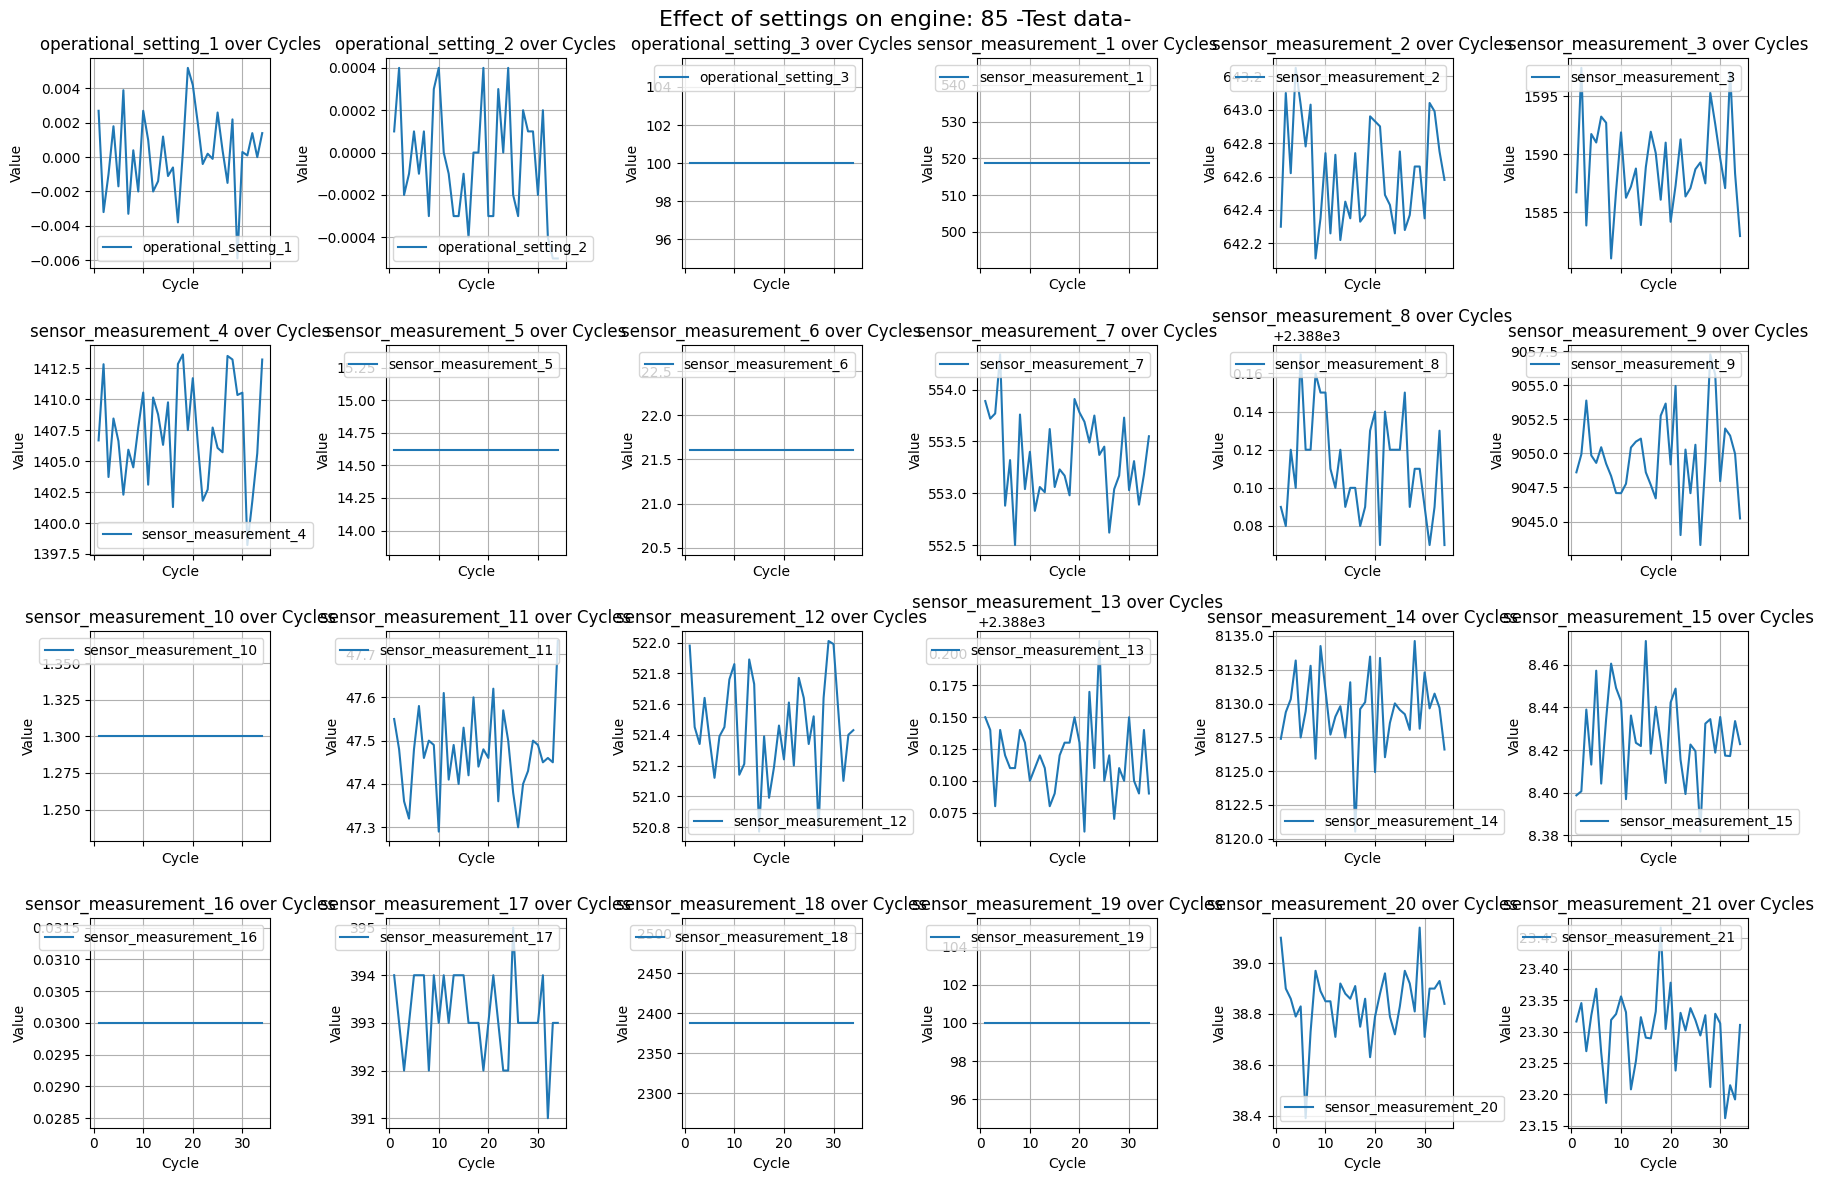

In [12]:
engine_number  = 85
engine_data = test_data[test_data['engine_id']==engine_number]

columns_to_plot = [f'operational_setting_{i}' for  i in range(1,4)] + [f'sensor_measurement_{i}' for i in range(1,22)]
num_cols = 6
num_rows = (len(columns_to_plot)  // num_cols)

fig,axes = plt.subplots(num_rows,num_cols,figsize=(18, num_rows * 3), sharex=True)

for ax, column in zip(axes.flatten(), columns_to_plot):
    ax.plot(engine_data['cycle'], engine_data[column], label=column)
    ax.set_title(f'{column} over Cycles')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

# Adjust the layout so that subgraphs do not overlap
plt.suptitle(f"Effect of settings on engine: {engine_number} -Test data-",fontsize=16)
plt.tight_layout()
plt.show()

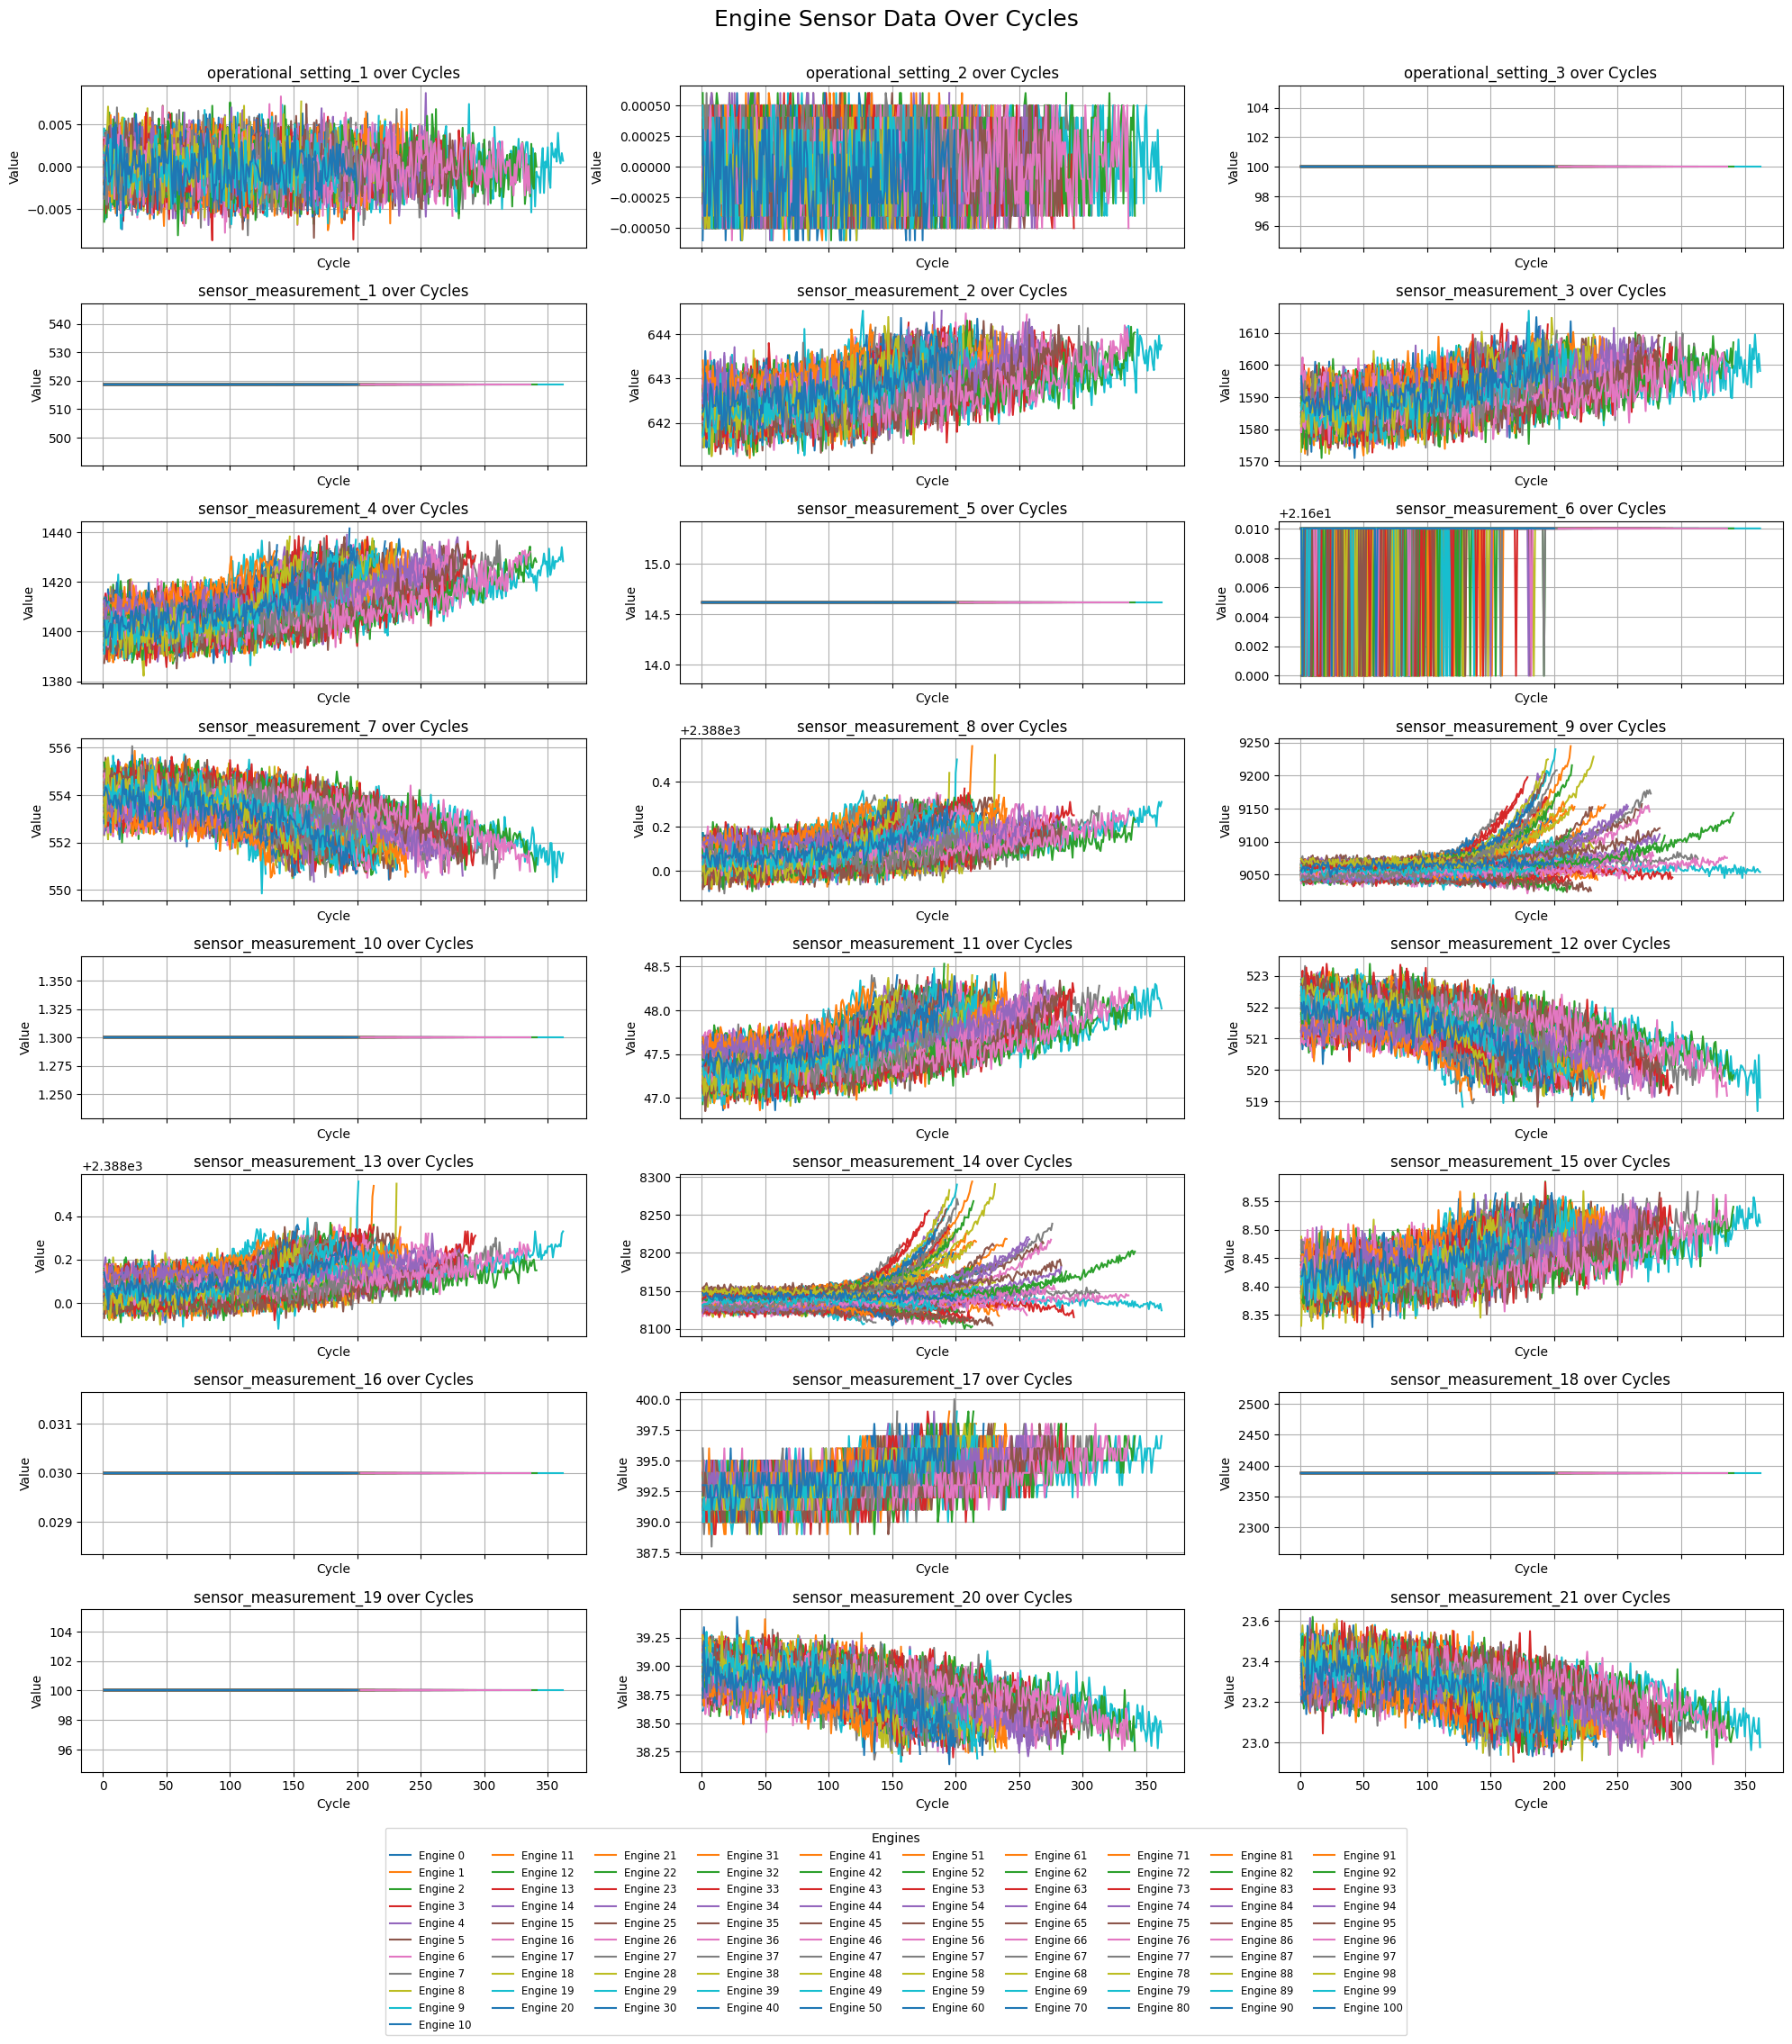

In [13]:
engines_to_plot =range(0,101)

columns_to_plot = [f'operational_setting_{i}' for  i in range(1,4)] + [f'sensor_measurement_{i}' for i in range(1,22)]
num_cols = 3
num_rows = len(columns_to_plot) // num_cols

fig,axes = plt.subplots(num_rows,num_cols,figsize=(20, num_rows * 3),sharex=True)

for engine_number in engines_to_plot:
    engine_data = train_data[train_data['engine_id']==engine_number]
    for ax,column in zip(axes.flatten(),columns_to_plot):
        ax.plot(engine_data['cycle'],engine_data[column],label=f'Engine {engine_number}')
        ax.set_title(f'{column} over Cycles')
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Value')
        ax.grid(True)

plt.tight_layout(rect=[0, 0.1, 1, 0.92])
fig.suptitle('Engine Sensor Data Over Cycles', fontsize=18, y=0.94)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels[:len(engines_to_plot)], loc='lower center', bbox_to_anchor=(0.5, 0), ncol=10, fontsize='small', title="Engines")
plt.show()   

In [14]:
# Calculate correlation matrix
corr_matrix = train_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [15]:
ml_train_data = train_data.drop(columns=['operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'])
ml_test_data = test_data.drop(columns=['operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'])
ml_train_data.head()

engine_id  cycle  operational_setting_1  operational_setting_2  \
0          1      1                -0.0007                -0.0004   
1          1      2                 0.0019                -0.0003   
2          1      3                -0.0043                 0.0003   
3          1      4                 0.0007                 0.0000   
4          1      5                -0.0019                -0.0002   

   sensor_measurement_2  sensor_measurement_3  sensor_measurement_4  \
0                641.82               1589.70               1400.60   
1                642.15               1591.82               1403.14   
2                642.35               1587.99               1404.20   
3                642.35               1582.79               1401.87   
4                642.37               1582.85               1406.22   

   sensor_measurement_6  sensor_measurement_7  sensor_measurement_8  \
0                 21.61                554.36               2388.06   
1                 21.61                553.75               2388.04   
2                 21.61                554.26               2388.08   
3                 21.61                554.45               2388.11   
4                 21.61                554.00               2388.06   

   sensor_measurement_9  sensor_measurement_11  sensor_measurement_12  \
0               9046.19                  47.47                 521.66   
1               9044.07                  47.49                 522.28   
2               9052.94                  47.27                 522.42   
3               9049.48                  47.13                 522.86   
4               9055.15                  47.28                 522.19   

   sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                2388.02                8138.62                 8.4195   
1                2388.07                8131.49                 8.4318   
2                2388.03                8133.23                 8.4178   
3                2388.08                8133.83                 8.3682   
4                2388.04                8133.80                 8.4294   

   sensor_measurement_17  sensor_measurement_20  sensor_measurement_21  RUL  
0                    392                  39.06                23.4190  191  
1                    392                  39.00                23.4236  190  
2                    390                  38.95                23.3442  189  
3                    392                  38.88                23.3739  188  
4                    393                  38.90                23.4044  187

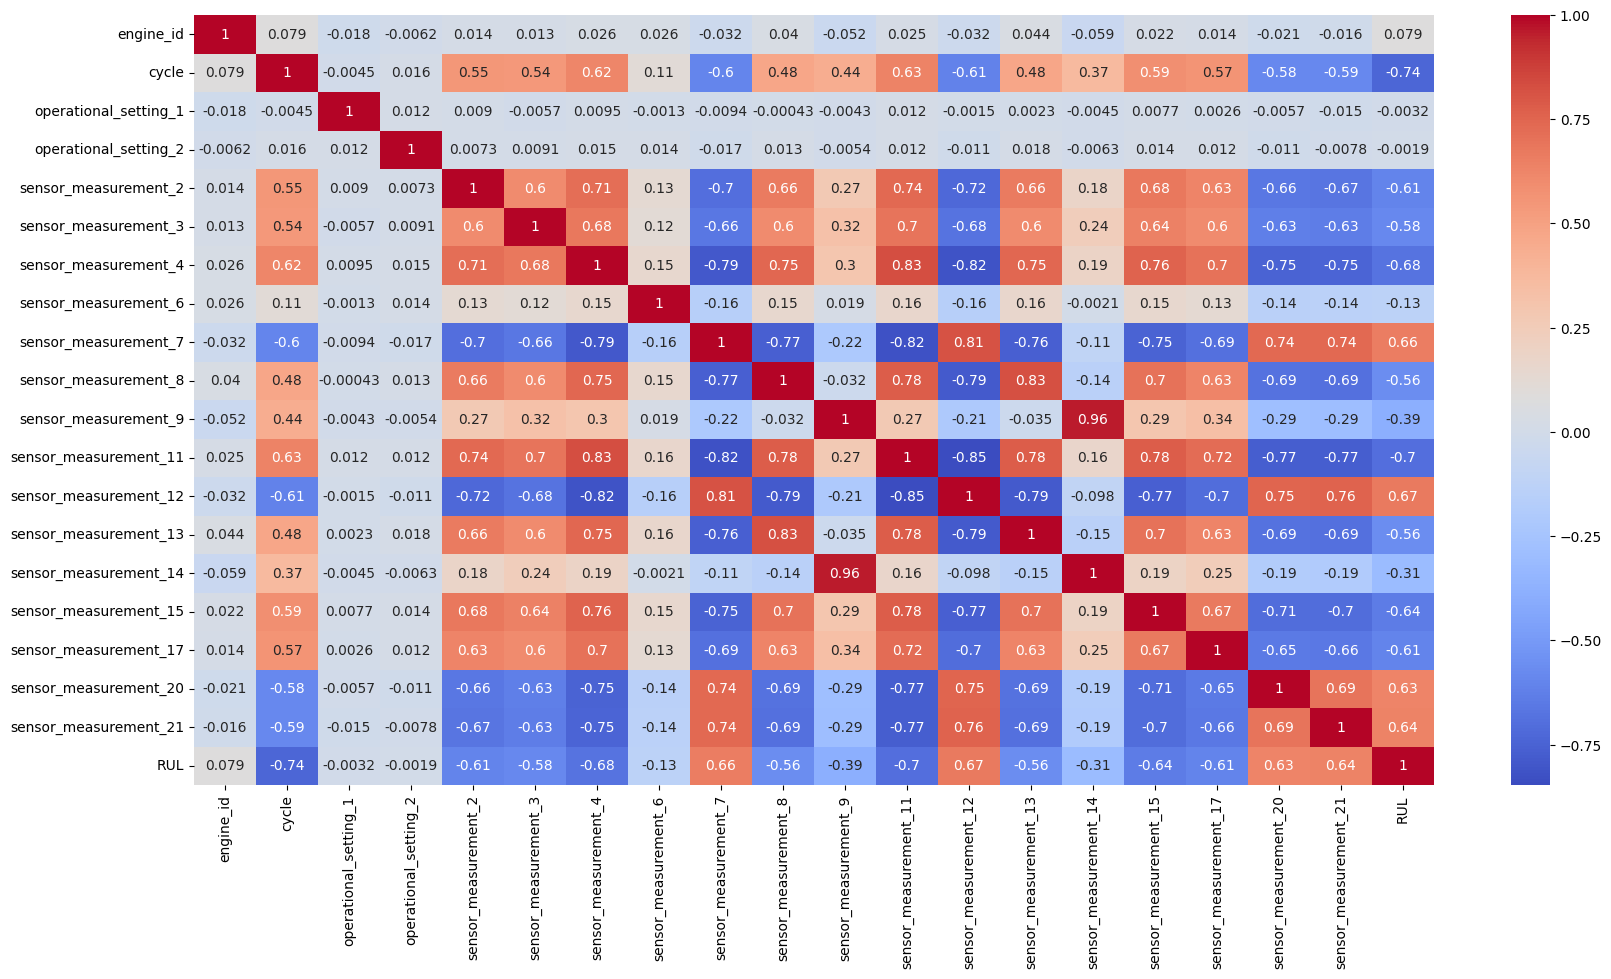

In [16]:
corr_matrix = ml_train_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [17]:
# Split the data into training and validation sets
X = ml_train_data.drop(columns=['RUL', 'engine_id', 'cycle'])
y = ml_train_data['RUL']

In [18]:
features_to_standardize = ['operational_setting_1', 'operational_setting_2',
       'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4',
       'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8',
       'sensor_measurement_9', 'sensor_measurement_11',
       'sensor_measurement_12', 'sensor_measurement_13',
       'sensor_measurement_14', 'sensor_measurement_15',
       'sensor_measurement_17', 'sensor_measurement_20',
       'sensor_measurement_21']

scaler = StandardScaler()
X[features_to_standardize] = scaler.fit_transform(X[features_to_standardize])
X.head()

operational_setting_1  operational_setting_2  sensor_measurement_2  \
0              -0.315980              -1.372953             -1.721725   
1               0.872722              -1.031720             -1.061780   
2              -1.961874               1.015677             -0.661813   
3               0.324090              -0.008022             -0.661813   
4              -0.864611              -0.690488             -0.621816   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_6  \
0             -0.134255             -0.925936              0.141683   
1              0.211528             -0.643726              0.141683   
2             -0.413166             -0.525953              0.141683   
3             -1.261314             -0.784831              0.141683   
4             -1.251528             -0.301518              0.141683   

   sensor_measurement_7  sensor_measurement_8  sensor_measurement_9  \
0              1.121141             -0.516338             -0.862813   
1              0.431930             -0.798093             -0.958818   
2              1.008155             -0.234584             -0.557139   
3              1.222827              0.188048             -0.713826   
4              0.714393             -0.516338             -0.457059   

   sensor_measurement_11  sensor_measurement_12  sensor_measurement_13  \
0              -0.266467               0.334262              -1.058890   
1              -0.191583               1.174899              -0.363646   
2              -1.015303               1.364721              -0.919841   
3              -1.539489               1.961302              -0.224597   
4              -0.977861               1.052871              -0.780793   

   sensor_measurement_14  sensor_measurement_15  sensor_measurement_17  \
0              -0.269071              -0.603816              -0.781710   
1              -0.642845              -0.275852              -0.781710   
2              -0.551629              -0.649144              -2.073094   
3              -0.520176              -1.971665              -0.781710   
4              -0.521748              -0.339845              -0.136018   

   sensor_measurement_20  sensor_measurement_21  
0               1.348493               1.194427  
1               1.016528               1.236922  
2               0.739891               0.503423  
3               0.352598               0.777792  
4               0.463253               1.059552

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
models = {
    'RandomForest' : RandomForestRegressor(),
    'GradientBoosting' : GradientBoostingRegressor(),
    'SVR' : SVR(),
    'Ridge' : Ridge()
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10],
        'subsample': [0.8, 1.0]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10],
        'solver': ['auto', 'svd', 'cholesky']
    }
}


# Perform GridSearchCV for each model
best_models = {}
for model_name in models.keys():
    print(f"Running GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(estimator=models[model_name], 
                               param_grid=param_grids[model_name], 
                               cv=5, 
                               scoring='neg_mean_squared_error', 
                               n_jobs=-1, 
                               verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_


# Print out the best models and their parameters
for model_name, model in best_models.items():
    print(f"\nBest {model_name} Model:\n{model}")

Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Running GridSearchCV for GradientBoosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Running GridSearchCV for SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running GridSearchCV for Ridge...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best RandomForest Model:
RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=500)

Best GradientBoosting Model:
GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          subsample=0.8)

Best SVR Model:
SVR(C=10)

Best Ridge Model:
Ridge(alpha=10)


In [25]:
mae = {}
mse = {}
rmse = {}
r2 = {}


for model_name, model in best_models.items():
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate evaluation metrics
    mae[model_name] = mean_absolute_error(y_val, y_pred)
    mse[model_name] = mean_squared_error(y_val, y_pred)
    rmse[model_name] = mse[model_name] ** 0.5
    r2[model_name] = r2_score(y_val, y_pred)
    
    # Print the metrics
    print(f"\nModel: {model_name}")
    print(f"Validation MAE: {mae[model_name]:.4f}")
    print(f"Validation MSE: {mse[model_name]:.4f}")
    print(f"Validation RMSE: {rmse[model_name]:.4f}")
    print(f"Validation R-squared: {r2[model_name]:.4f}")


Model: RandomForest
Validation MAE: 29.3194
Validation MSE: 1687.7211
Validation RMSE: 41.0819
Validation R-squared: 0.6306

Model: GradientBoosting
Validation MAE: 29.4391
Validation MSE: 1684.2988
Validation RMSE: 41.0402
Validation R-squared: 0.6313

Model: SVR
Validation MAE: 29.2556
Validation MSE: 1742.7920
Validation RMSE: 41.7468
Validation R-squared: 0.6185

Model: Ridge
Validation MAE: 34.0497
Validation MSE: 1966.1488
Validation RMSE: 44.3413
Validation R-squared: 0.5697


In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Bar plot for MAE
axes[0, 0].bar(mae.keys(), mae.values(), color='skyblue')
axes[0, 0].set_title('MAE for Each Model')
axes[0, 0].set_ylabel('MAE')

# Bar plot for MSE
axes[0, 1].bar(mse.keys(), mse.values(), color='lightgreen')
axes[0, 1].set_title('MSE for Each Model')
axes[0, 1].set_ylabel('MSE')

# Bar plot for RMSE
axes[1, 0].bar(rmse.keys(), rmse.values(), color='salmon')
axes[1, 0].set_title('RMSE for Each Model')
axes[1, 0].set_ylabel('RMSE')

# Bar plot for R-squared
axes[1, 1].bar(r2.keys(), r2.values(), color='orange')
axes[1, 1].set_title('R-squared for Each Model')
axes[1, 1].set_ylabel('R-squared')

# Adjust layout
plt.tight_layout()
plt.show()